In [87]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import holidays
import pycountry
import optuna

import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [88]:
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

# Check available GPUs
gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"GPU is available with {gpu_count} GPU(s).")
else:
    print("No GPU detected. Ensure your setup is correct.")

# Test CatBoost with GPU
try:
    model = CatBoostClassifier(task_type="GPU", devices='0')  # Specify GPU
    device = 'gpu'
    print("CatBoost can use the GPU.")
        
except Exception as e:
    device = 'cpu'
    print(f"Error: {e}")

GPU is available with 1 GPU(s).
CatBoost can use the GPU.


In [89]:
# Declare important variables
train_path = 'train.csv'
test_path = 'test.csv'
submission_path = 'sample_submission.csv'
target_variable = 'num_sold'
SEED = 69
skip_hypertuning = True
cat_encoder_type = 'OneHotEncoder' #OneHotEncoder, FrequencyEncoder, None

In [90]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    print(f"Loading data from {os.getcwd()}")
    
    return df1, df2

In [91]:
train, test = load_dataframes(train_path,test_path)

Loading data from C:\Users\ZaneC\OneDrive\Documents\Python\Kaggle\Playground Series\s5e1 - Sticker Sales


In [92]:
# add the 'dataset' column to distinguish train and test data
train['dataset'] = 'train'
test['dataset'] = 'test'

# concatenate the datasets with the added 'dataset' column
df = pd.concat([train, test], axis=0).reset_index(drop=True)
df = df.rename(columns={target_variable: 'y'})

In [93]:
#plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

In [94]:
#plot_kde_grid(df_solve,n_cols=4,figsize=(9,6))

In [95]:
def get_num_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['number']).columns.to_list()
    
    return num_cols

def get_cat_cols(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()  

    return cat_cols

In [96]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()   
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    inf['count'] = df.shape[0]

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [97]:
describe_dataframe(df, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,328680,0,328680,0.000000,328679.000000,164339.500000,94881.887576,nan,nan
1,date,object,0,0.000000,3652,0,328680,nan,nan,nan,nan,2010-01-01,90
2,country,object,0,0.000000,6,0,328680,nan,nan,nan,nan,Canada,54780
3,store,object,0,0.000000,3,0,328680,nan,nan,nan,nan,Discount Stickers,109560
4,product,object,0,0.000000,5,0,328680,nan,nan,nan,nan,Holographic Goose,65736
5,y,float64,107421,32.682548,4037,0,328680,5.000000,5939.000000,752.527382,690.165445,nan,nan
6,dataset,object,0,0.000000,2,0,328680,nan,nan,nan,nan,train,230130


<Figure size 1000x600 with 0 Axes>

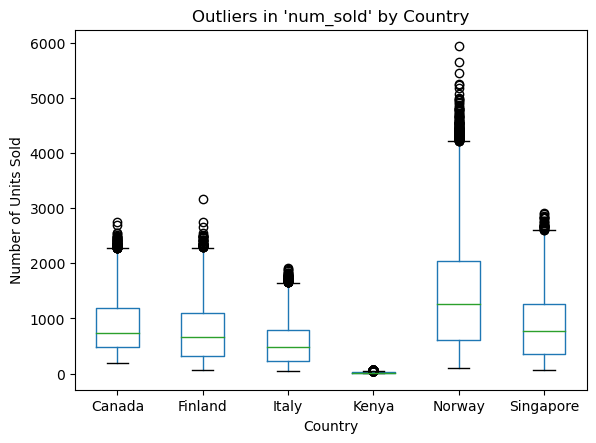

In [98]:
plt.figure(figsize=(10, 6))
df.boxplot(column='y', by='country', grid=False)
plt.title("Outliers in 'num_sold' by Country")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel('Number of Units Sold')
plt.xlabel('Country')
plt.show()

<Figure size 1000x600 with 0 Axes>

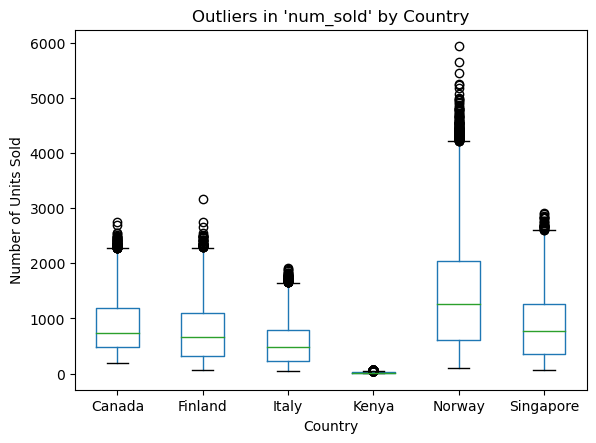

In [99]:
plt.figure(figsize=(10, 6))
df.boxplot(column='y', by='country', grid=False)
plt.title("Outliers in 'num_sold' by Country")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel('Number of Units Sold')
plt.xlabel('Country')
plt.show()

In [100]:
# Calculate Outlier Bounds Using IQR
# Calculating Interquartile Range (IQR) to identify potential outliers
# Filtering rows where 'num_sold' is outside the lower and upper bounds

# Recalculate Q1, Q3, and IQR
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['y'] < lower_bound) | (df['y'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

Number of Outliers: 6630


In [101]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_nulls: bool = True, fill_cat_nulls: bool = True) -> None:
    df = df_to_use.copy()

    # Convert date column from object to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=['number']).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Target field 'num_sold' is missing some values, we do not want to impute them
    if 'y' in missing_numeric_columns:
        missing_numeric_columns.remove('y')
    
    # Fill nulls in numeric columns with the median
    if impute_num_nulls:       
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)

    
    # Get category columns
    if fill_cat_nulls:
        cat_cols = df.select_dtypes(include=['object', 'string','category']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('None')
    
    return df

In [102]:
df = clean_dataframe(df, impute_num_nulls = True, fill_cat_nulls=False)

In [103]:
describe_dataframe(df, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,328680,0,328680,0.000000,328679.000000,164339.500000,94881.887576,nan,nan
1,date,datetime64[ns],0,0.000000,3652,0,328680,2010-01-01 00:00:00,2019-12-31 00:00:00,2014-12-31 12:00:00,nan,nan,nan
2,country,object,0,0.000000,6,0,328680,nan,nan,nan,nan,Canada,54780
3,store,object,0,0.000000,3,0,328680,nan,nan,nan,nan,Discount Stickers,109560
4,product,object,0,0.000000,5,0,328680,nan,nan,nan,nan,Holographic Goose,65736
5,y,float64,107421,32.682548,4037,0,328680,5.000000,5939.000000,752.527382,690.165445,nan,nan
6,dataset,object,0,0.000000,2,0,328680,nan,nan,nan,nan,train,230130


In [104]:
def get_holiday_name(country_code, date_obj):
    try:
        country_holiday = holidays.CountryHoliday(country_code, years=date_obj.year)
        return country_holiday.get(date_obj)
    except Exception as e:
        print(f"Error for country code {country_code} and date {date_obj}: {e}")
        return 'Invalid Holiday'
    return country_holiday.get(date_obj)

def get_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_2  
    except KeyError:
        print(f"Unknown Country: {country_name}")
        return None

def get_holiday_for_row(row):
    country_code = get_country_code(row['country'])
    if country_code is None:
        return 'Unknown Country'     
    try:
        date_obj = row['date']
    except ValueError:
        print(f"Invalid Date: {row['date']}")
        return 'Invalid Date'

    return get_holiday_name(country_code, date_obj)


df['holiday'] = df.apply(get_holiday_for_row, axis=1)


In [105]:

df['Year'] = df['date'].dt.year
df['Quarter'] = df['date'].dt.quarter
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week

df['day_sin'] = np.sin(2 * np.pi * df['Day'] / 365.0)
df['day_cos'] = np.cos(2 * np.pi * df['Day'] / 365.0)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
df['year_sin'] = np.sin(2 * np.pi * df['Year'] / 7.0)
df['year_cos'] = np.cos(2 * np.pi * df['Year'] / 7.0)
df['Group']=(df['Year']-2010)*48+df['Month']*4+df['Day']//7


df['Quarter'] = df['Quarter'].astype('str')
df['Month'] = df['Month'].astype('str')
df['day_of_week'] = df['day_of_week'].astype('str')
df['day_of_year'] = df['day_of_week'].astype('str')
df['week_of_year'] = df['week_of_year'].astype('str')


In [106]:
RMV = ['y','dataset','id','date']
FEATURES = [c for c in df.columns if not c in RMV]

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = "numerical"
    if df[c].dtype=="object":
        CATS.append(c)
        df[c] = df[c].fillna("NAN")
        df[c],_ = df[c].factorize()
        df[c] -= df[c].min()
        ftype = "categorical"
    if df[c].dtype=="int64":
        df[c] = df[c].astype("int32")
    elif df[c].dtype=="float64":
        df[c] = df[c].astype("float32")

    n = df[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=9: HIGH_CARDINALITY.append(c)

print("\nTHE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )

THE 18 BASIC FEATURES ARE:
country (categorical) with 6 unique values
store (categorical) with 3 unique values
product (categorical) with 5 unique values
holiday (categorical) with 75 unique values
Year (numerical) with 10 unique values
Quarter (categorical) with 4 unique values
Month (categorical) with 12 unique values
Day (numerical) with 31 unique values
day_of_week (categorical) with 7 unique values
day_of_year (categorical) with 7 unique values
week_of_year (categorical) with 53 unique values
day_sin (numerical) with 31 unique values
day_cos (numerical) with 31 unique values
month_sin (numerical) with 8 unique values
month_cos (numerical) with 8 unique values
year_sin (numerical) with 7 unique values
year_cos (numerical) with 4 unique values
Group (numerical) with 481 unique values

THE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES: ['holiday', 'Year', 'Month', 'Day', 'week_of_year', 'day_sin', 'day_cos', 'Group']


In [107]:
describe_dataframe(df, name='Sales Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,328680,0,328680,0.000000,328679.000000,164339.500000,94881.887576,nan,nan
1,date,datetime64[ns],0,0.000000,3652,0,328680,2010-01-01 00:00:00,2019-12-31 00:00:00,2014-12-31 12:00:00,nan,nan,nan
2,country,int32,0,0.000000,6,0,328680,0.000000,5.000000,2.500000,1.707828,nan,nan
3,store,int32,0,0.000000,3,0,328680,0.000000,2.000000,1.000000,0.816498,nan,nan
4,product,int32,0,0.000000,5,0,328680,0.000000,4.000000,2.000000,1.414216,nan,nan
5,y,float64,107421,32.682548,4037,0,328680,5.000000,5939.000000,752.527382,690.165445,nan,nan
6,dataset,object,0,0.000000,2,0,328680,nan,nan,nan,nan,train,230130
7,holiday,int32,0,0.000000,75,0,328680,0.000000,74.000000,4.791804,5.508516,nan,nan
8,Year,int32,0,0.000000,10,0,328680,2010.000000,2019.000000,2014.499726,2.871904,nan,nan
9,Quarter,int32,0,0.000000,4,0,328680,0.000000,3.000000,1.508762,1.117021,nan,nan


In [108]:
# replace with zero 
# Drop rows where 'dataset' is 'train' and 'num_sold' is NaN
df = df[~((df['dataset'] == 'train') & (df['y'].isna()))]

In [109]:
# Apply a logarithmic transformation to 'num_sold' to reduce skewness and stabilize variance.
# This transformation helps to handle outliers by compressing large values, making the data 
# more suitable for statistical analysis and modeling.
df['y'] = np.log(df['y'])

In [110]:
# Encoding categorical variables (country, store, product) as dummy variables
# Avoiding the dummy variable trap by dropping the first category in each column

df = pd.get_dummies(df, columns=['country', 'store', 'product'], dtype=int, drop_first=True)

In [111]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='date',y='y',hue='product')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);`

In [112]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Day of Year',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [113]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Week of Year',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [114]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Month',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [115]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Year',y='y', hue='country')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [116]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Day of Year Sin',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [117]:
# Splitting the training dataset into train and validation sets
# Ensuring the split preserves the time series order

# Separate train and test datasets
train_df = df[df['dataset'] == 'train'].drop(columns=['dataset'], errors='ignore')
test_df = df[df['dataset'] == 'test'].drop(columns=['dataset'], errors='ignore')


# Drop unnecessary columns from both datasets
train_df = train_df.drop(columns=['id'], errors='ignore')
test_df = test_df.drop(columns=['y'], errors='ignore')

# Sort training data by date to preserve time series order
train_df = train_df.sort_values(by='date')

# Let's define a split date or index
train_size = int(len(train_df) * 0.86)  # 80% for training
df_train = train_df.iloc[:train_size]
df_test = train_df.iloc[train_size:]

# Separate features and target
x_train = df_train.drop(['y'], axis=1)
y_train = df_train['y']
x_test = df_test.drop(['y'], axis=1)
y_test = df_test['y']



# Drop the 'date' column after feature extraction
x_train = x_train.drop(columns=['date'], errors='ignore')
x_test = x_test.drop(columns=['date'], errors='ignore')

In [118]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Define the objective function for Optuna, which evaluates LightGBM's performance
def objective(trial):
    # Suggest hyperparameter values to be optimized by Optuna
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),  # Maximum leaves in one tree
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),  # Learning rate for gradient boosting
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),  # Number of boosting rounds
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Fraction of samples used per iteration
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Fraction of features used for each tree
        "random_state": 42,  # Ensures reproducibility
    }
    
    # Use TimeSeriesSplit to preserve temporal order during cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    model = LGBMRegressor(**params)  # Initialize the LightGBM model with current parameters
    
    errors = []  # List to store validation errors for each fold
    for train_index, val_index in tscv.split(x_train):  # Split training data for cross-validation
        x_train_cv, X_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]  # Train/validation splits
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(x_train_cv, y_train_cv)  # Train the model on the current fold
        y_val_pred = model.predict(X_val_cv)  # Predict on the validation set
        errors.append(mean_squared_error(y_val_cv, y_val_pred))  # Calculate and store MSE
    
    # Calculate the Root Mean Squared Error (RMSE) for the current trial
    rmse = np.sqrt(np.mean(errors))
    return rmse  # Return RMSE as the objective value for Optuna to minimize

# Initialize an Optuna study for hyperparameter optimization
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=35)  # Optimize the objective function over 30 trials

# Print the best hyperparameters found during optimization
print("Best trial:", study.best_trial.params)

[I 2025-01-11 15:08:41,705] A new study created in memory with name: no-name-b0ff5dcf-fb7b-4554-b9d2-1cd4e7d3c3d9


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:08:48,255] Trial 0 finished with value: 1.3591522997899843 and parameters: {'num_leaves': 58, 'learning_rate': 0.00030596264725014997, 'n_estimators': 600, 'subsample': 0.5003847159379098, 'colsample_bytree': 0.7065911405314493}. Best is trial 0 with value: 1.3591522997899843.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:08:57,483] Trial 1 finished with value: 1.3498001122262162 and parameters: {'num_leaves': 122, 'learning_rate': 0.000279028617250203, 'n_estimators': 500, 'subsample': 0.7554377981170751, 'colsample_bytree': 0.9587729325484207}. Best is trial 1 with value: 1.3498001122262162.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:09:00,904] Trial 2 finished with value: 0.8440817776288637 and parameters: {'num_leaves': 98, 'learning_rate': 0.0039497299786651965, 'n_estimators': 200, 'subsample': 0.9351274899126472, 'colsample_bytree': 0.7170645835801746}. Best is trial 2 with value: 0.8440817776288637.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:09:06,062] Trial 3 finished with value: 1.4153765283207749 and parameters: {'num_leaves': 27, 'learning_rate': 0.00018642415357011336, 'n_estimators': 600, 'subsample': 0.5472755964807138, 'colsample_bytree': 0.7949640921092485}. Best is trial 2 with value: 0.8440817776288637.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:09:11,716] Trial 4 finished with value: 0.11157810133687203 and parameters: {'num_leaves': 60, 'learning_rate': 0.05723166838626199, 'n_estimators': 600, 'subsample': 0.7417938695380206, 'colsample_bytree': 0.545419126046581}. Best is trial 4 with value: 0.11157810133687203.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:09:22,326] Trial 5 finished with value: 0.11047240935358875 and parameters: {'num_leaves': 79, 'learning_rate': 0.0239645880455166, 'n_estimators': 800, 'subsample': 0.5748724256805376, 'colsample_bytree': 0.654043866476663}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:09:38,868] Trial 6 finished with value: 1.3165370358274582 and parameters: {'num_leaves': 120, 'learning_rate': 0.00028238247732873434, 'n_estimators': 900, 'subsample': 0.5156524527419994, 'colsample_bytree': 0.631529021716627}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:09:42,535] Trial 7 finished with value: 1.4981175304354395 and parameters: {'num_leaves': 51, 'learning_rate': 0.00013713329682619628, 'n_estimators': 300, 'subsample': 0.6151406006623192, 'colsample_bytree': 0.7965723665478082}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:09:48,622] Trial 8 finished with value: 0.3128024437435084 and parameters: {'num_leaves': 116, 'learning_rate': 0.00563848339920459, 'n_estimators': 300, 'subsample': 0.9190303932349653, 'colsample_bytree': 0.9168614086503426}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:09:52,210] Trial 9 finished with value: 0.11400204148251693 and parameters: {'num_leaves': 48, 'learning_rate': 0.04389313986238294, 'n_estimators': 300, 'subsample': 0.9059729604514164, 'colsample_bytree': 0.6522548921967508}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:10:07,465] Trial 10 finished with value: 0.11362782345998983 and parameters: {'num_leaves': 86, 'learning_rate': 0.016616025889245937, 'n_estimators': 1000, 'subsample': 0.6909607087715379, 'colsample_bytree': 0.5054115635979848}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:10:16,225] Trial 11 finished with value: 0.1125517299642511 and parameters: {'num_leaves': 78, 'learning_rate': 0.09329896990182203, 'n_estimators': 800, 'subsample': 0.8195493021745273, 'colsample_bytree': 0.5170760190765897}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:10:26,093] Trial 12 finished with value: 0.11205301315907079 and parameters: {'num_leaves': 68, 'learning_rate': 0.018995900687655727, 'n_estimators': 700, 'subsample': 0.6651262008613955, 'colsample_bytree': 0.5880279273163184}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:10:32,040] Trial 13 finished with value: 0.11104371164923081 and parameters: {'num_leaves': 30, 'learning_rate': 0.09709762919721009, 'n_estimators': 800, 'subsample': 0.8065399663563843, 'colsample_bytree': 0.5772591738099457}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:10:38,286] Trial 14 finished with value: 0.12177821768561287 and parameters: {'num_leaves': 17, 'learning_rate': 0.01740757986833072, 'n_estimators': 800, 'subsample': 0.8354785754812157, 'colsample_bytree': 0.6270402659368634}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:10:50,296] Trial 15 finished with value: 0.7130780951717218 and parameters: {'num_leaves': 36, 'learning_rate': 0.0011347640098913027, 'n_estimators': 1000, 'subsample': 0.5933276527526785, 'colsample_bytree': 0.677819597107236}. Best is trial 5 with value: 0.11047240935358875.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:11:02,669] Trial 16 finished with value: 0.11033385267729535 and parameters: {'num_leaves': 92, 'learning_rate': 0.03230057220755551, 'n_estimators': 800, 'subsample': 0.8384737368308744, 'colsample_bytree': 0.5790323473317228}. Best is trial 16 with value: 0.11033385267729535.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:11:12,696] Trial 17 finished with value: 0.12455815993120688 and parameters: {'num_leaves': 98, 'learning_rate': 0.008758289806391286, 'n_estimators': 500, 'subsample': 0.8647394834096163, 'colsample_bytree': 0.8085935008854861}. Best is trial 16 with value: 0.11033385267729535.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:11:30,396] Trial 18 finished with value: 0.7462204826668773 and parameters: {'num_leaves': 100, 'learning_rate': 0.001330456009390203, 'n_estimators': 900, 'subsample': 0.9712484860340498, 'colsample_bytree': 0.6076709897264065}. Best is trial 16 with value: 0.11033385267729535.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:11:41,403] Trial 19 finished with value: 0.10955227161752122 and parameters: {'num_leaves': 90, 'learning_rate': 0.028631316607835845, 'n_estimators': 700, 'subsample': 0.7483541535600521, 'colsample_bytree': 0.7501637716908929}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:11:56,436] Trial 20 finished with value: 0.44153966622118423 and parameters: {'num_leaves': 109, 'learning_rate': 0.0019869821784813794, 'n_estimators': 700, 'subsample': 0.7637265807445338, 'colsample_bytree': 0.8869665186554825}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:12:07,039] Trial 21 finished with value: 0.11096680269917955 and parameters: {'num_leaves': 84, 'learning_rate': 0.03412252462922496, 'n_estimators': 700, 'subsample': 0.7001551005029879, 'colsample_bytree': 0.7495853529166842}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:12:23,230] Trial 22 finished with value: 0.1130055767590491 and parameters: {'num_leaves': 89, 'learning_rate': 0.00990799480715604, 'n_estimators': 900, 'subsample': 0.6285098722838609, 'colsample_bytree': 0.6786033900596655}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:12:34,383] Trial 23 finished with value: 0.11029125206745156 and parameters: {'num_leaves': 74, 'learning_rate': 0.028230660069915377, 'n_estimators': 800, 'subsample': 0.8723732215165141, 'colsample_bytree': 0.8524101390775347}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:12:45,707] Trial 24 finished with value: 0.11348368920087688 and parameters: {'num_leaves': 73, 'learning_rate': 0.009868565167557138, 'n_estimators': 700, 'subsample': 0.8620638888334505, 'colsample_bytree': 0.8567585089066903}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:12:53,624] Trial 25 finished with value: 0.11013483156340284 and parameters: {'num_leaves': 106, 'learning_rate': 0.05048592696020243, 'n_estimators': 400, 'subsample': 0.7819157114650993, 'colsample_bytree': 0.8505325587130811}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:13:00,819] Trial 26 finished with value: 0.10973396193959152 and parameters: {'num_leaves': 107, 'learning_rate': 0.058129448907374266, 'n_estimators': 400, 'subsample': 0.7786387238641987, 'colsample_bytree': 0.8480583231734742}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:13:07,567] Trial 27 finished with value: 0.10998916480365849 and parameters: {'num_leaves': 107, 'learning_rate': 0.06268393447768296, 'n_estimators': 400, 'subsample': 0.779224284933554, 'colsample_bytree': 0.9537877023105363}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:13:10,235] Trial 28 finished with value: 0.11136457590564795 and parameters: {'num_leaves': 128, 'learning_rate': 0.07309970717247657, 'n_estimators': 100, 'subsample': 0.7210619590895609, 'colsample_bytree': 0.9633427098350104}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:13:18,581] Trial 29 finished with value: 1.2126848831687704 and parameters: {'num_leaves': 111, 'learning_rate': 0.0006370253199256776, 'n_estimators': 400, 'subsample': 0.7898365147578714, 'colsample_bytree': 0.9245433898536943}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:13:25,097] Trial 30 finished with value: 0.11136126054869973 and parameters: {'num_leaves': 103, 'learning_rate': 0.0586469330660691, 'n_estimators': 400, 'subsample': 0.6543186971039305, 'colsample_bytree': 0.7449691690286546}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:13:31,853] Trial 31 finished with value: 0.11074998912693637 and parameters: {'num_leaves': 107, 'learning_rate': 0.05269109601089493, 'n_estimators': 400, 'subsample': 0.7860268867102572, 'colsample_bytree': 0.8416804911019953}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:13:39,896] Trial 32 finished with value: 0.10992214123513673 and parameters: {'num_leaves': 96, 'learning_rate': 0.04151757238154457, 'n_estimators': 500, 'subsample': 0.7371495057870961, 'colsample_bytree': 0.9251184931584331}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:13:49,394] Trial 33 finished with value: 0.11209974116480119 and parameters: {'num_leaves': 97, 'learning_rate': 0.013819004808100508, 'n_estimators': 500, 'subsample': 0.7639130524515255, 'colsample_bytree': 0.9934738643294859}. Best is trial 19 with value: 0.10955227161752122.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 26
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 26
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-11 15:14:00,164] Trial 34 finished with value: 0.10916081923210903 and parameters: {'num_leaves': 115, 'learning_rate': 0.03504514673967671, 'n_estimators': 600, 'subsample': 0.7318909906459061, 'colsample_bytree': 0.9155705430641332}. Best is trial 34 with value: 0.10916081923210903.


Best trial: {'num_leaves': 115, 'learning_rate': 0.03504514673967671, 'n_estimators': 600, 'subsample': 0.7318909906459061, 'colsample_bytree': 0.9155705430641332}


In [119]:
# Retrieve the best hyperparameters found during Optuna optimization
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

# Instantiate the LightGBM model using the best hyperparameters
final_model = LGBMRegressor(**best_params)

# Train the model on the training dataset
final_model.fit(x_train, y_train)

# Predict the target variable for the test dataset
y_test_pred = final_model.predict(x_test)

# Calculate Root Mean Squared Error (RMSE) for model evaluation
# RMSE indicates the average magnitude of prediction errors, lower is better
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Final test RMSE:", final_test_rmse)

# Calculate Mean Absolute Percentage Error (MAPE) for model evaluation
# MAPE shows the average percentage error between predicted and actual values, lower is better
final_test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print("Final test MAPE:", final_test_mape)

Best hyperparameters: {'num_leaves': 115, 'learning_rate': 0.03504514673967671, 'n_estimators': 600, 'subsample': 0.7318909906459061, 'colsample_bytree': 0.9155705430641332}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 190282, number of used features: 26
[LightGBM] [Info] Start training from score 5.937273
Final test RMSE: 0.08078035836239862
Final test MAPE: 0.01220820001448394


In [120]:
# Separate features (X) and target variable (y) from the training data
# Dropping 'num_sold' as it's the target variable
# Dropping 'date' to avoid any unintended leakage since it is not used as a feature
X = train_df.drop(columns=['y', 'date']).copy()
y = train_df['y'].copy()

# Retrieve the best hyperparameters from the Optuna study
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Instantiate the LightGBM model with the optimal hyperparameters
best_model = LGBMRegressor(**best_params)

# Train the model using all available training data (X, y)
best_model.fit(X, y)

Best hyperparameters: {'num_leaves': 115, 'learning_rate': 0.03504514673967671, 'n_estimators': 600, 'subsample': 0.7318909906459061, 'colsample_bytree': 0.9155705430641332}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 221259, number of used features: 26
[LightGBM] [Info] Start training from score 5.925537


LGBMRegressor(colsample_bytree=0.9155705430641332,
              learning_rate=0.03504514673967671, n_estimators=600,
              num_leaves=115, subsample=0.7318909906459061)

In [121]:
# Preprocess test data
test_features = test_df.drop(columns=['id', 'date'], errors='ignore')  # Drop unnecessary columns
test_features = test_features.reindex(columns=x_train.columns, fill_value=0)  # Align columns with training data

In [122]:
y_test_pred = best_model.predict(test_features)

In [123]:
sub = pd.read_csv(submission_path)
sub[target_variable] = np.expm1(y_test_pred)
sub.to_csv('Predictions_LGBM.csv', index=False)
print(sub.shape)
sub.head()

(98550, 2)


,id,num_sold
0,230130,173.877260
1,230131,964.990713
2,230132,741.810135
3,230133,384.992800
4,230134,480.034632
